The visualizations and insights of this notebook support the investment in the Yellow Cab company.

The following cell is the initial data cleaning phase. It creates data and subset of that data so that it can be reused in the cells thereafter.

I think it makes sense to remove outliers in profits (charge - cost) because there are questionable values and they skew the overall dataset in the places that matter more than a variable like cost.

However, removing profit outliers has clearly more of an dampening effect on the Yellow cab data since it was found to have no low profit outliers. 

This fact should further support the following evidence in favor of Yellow Cab.

Note: Rides and transactions are not assumed to be the same. See the assumptions in the data intake report.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from sklearn.metrics import r2_score
from datetime import datetime



def find_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    return np.where((data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR))[0]


cab_data = pd.read_csv("Cab_Data.csv")
transaction_id = pd.read_csv("Transaction_ID.csv")
customer_id = pd.read_csv("Customer_ID.csv")
city = pd.read_csv("City.csv")


print("NOF duplicate Transactions in cab_data:", cab_data[cab_data.duplicated("Transaction ID")]["Transaction ID"].count())
print("NOF duplicate Transactions in transaction_id:", transaction_id[transaction_id.duplicated("Transaction ID")]["Transaction ID"].count())
print("NOF duplicate Users:", customer_id[customer_id.duplicated("Customer ID")]["Customer ID"].count())


master = pd.merge(cab_data, transaction_id, on = "Transaction ID", how = "right")
master = pd.merge(master, customer_id, on = "Customer ID", how = "right")
master = pd.merge(master, city, on = "City", how = "right")


rows_with_null = master[master.isnull().any(axis=1)]
print("NOF rows with nulls:", len(rows_with_null))
print("City with no transactions:", rows_with_null["City"].values)


master = master.dropna()
rows_with_null = master[master.isnull().any(axis=1)]
print('NOF rows with nulls with "SAN FRANCISCO CA" row dropped:', len(rows_with_null))


master_pink = master[master["Company"] == "Pink Cab"].sort_values("Date of Travel").reset_index(drop=True)
master_yellow = master[master["Company"] == "Yellow Cab"].sort_values("Date of Travel").reset_index(drop=True)

# Potential variables with outliers...
# km, charge, cost, income

master_pink["profits"] = master_pink["Price Charged"]-master_pink["Cost of Trip"]
master_yellow["profits"] = master_yellow["Price Charged"]-master_yellow["Cost of Trip"]


pink_km_outlier_indices = find_outliers(master_pink["KM Travelled"])
yellow_km_outlier_indices = find_outliers(master_yellow["KM Travelled"])
print("NOF Pink km traveled outliers", len(pink_km_outlier_indices))
print("NOF Yellow km traveled outliers", len(yellow_km_outlier_indices))


pink_income_outlier_indices = find_outliers(master_pink["Income (USD/Month)"])
yellow_income_outlier_indices = find_outliers(master_yellow["Income (USD/Month)"])
print("NOF Pink income outliers", len(pink_income_outlier_indices))
print("NOF Yellow income outliers", len(yellow_income_outlier_indices))


pink_profit_outlier_indices = find_outliers(master_pink["profits"])
yellow_profit_outlier_indices = find_outliers(master_yellow["profits"])
print("NOF Pink profit outliers", len(pink_profit_outlier_indices))
print("NOF Yellow profit outliers", len(yellow_profit_outlier_indices))


filtered_pink = master_pink.drop(pink_profit_outlier_indices).reset_index(drop=True)
filtered_yellow = master_yellow.drop(yellow_profit_outlier_indices).reset_index(drop=True)


filtered_pink_2016 = filtered_pink[filtered_pink["Date of Travel"]<= 42735].reset_index(drop=True)
filtered_yellow_2016 = filtered_yellow[filtered_yellow["Date of Travel"]<= 42735].reset_index(drop=True)

filtered_pink_2017 = filtered_pink[(filtered_pink["Date of Travel"]>= 42736) & (filtered_pink["Date of Travel"]<= 43100)].reset_index(drop=True)
filtered_yellow_2017 = filtered_yellow[(filtered_yellow["Date of Travel"]>= 42736) & (filtered_yellow["Date of Travel"]<= 43100)].reset_index(drop=True)

filtered_pink_2018 = filtered_pink[filtered_pink["Date of Travel"]>= 43101].reset_index(drop=True)
filtered_yellow_2018 = filtered_yellow[filtered_yellow["Date of Travel"]>= 43101].reset_index(drop=True)



NOF duplicate Transactions in cab_data: 0
NOF duplicate Transactions in transaction_id: 0
NOF duplicate Users: 0
NOF rows with nulls: 1
City with no transactions: ['SAN FRANCISCO CA']
NOF rows with nulls with "SAN FRANCISCO CA" row dropped: 0
NOF Pink km traveled outliers 0
NOF Yellow km traveled outliers 0
NOF Pink income outliers 0
NOF Yellow income outliers 0
NOF Pink profit outliers 4074
NOF Yellow profit outliers 14129


Insights:

The output and visuals in the following cell show the profits for both cab companies for 2016 and 2018.

Yellow cab has a higher percentage increase in the total yearly profit from 2016 to 2018. Projecting this growth into the future supports Yellow Cabs investment.

Percent Increase in Pink Cab total yearly profits from 2016 to 2018: 0.05553981073845837
Percent Increase in Yellow Cab total yearly profits from 2016 to 2018: 0.06260588890138741


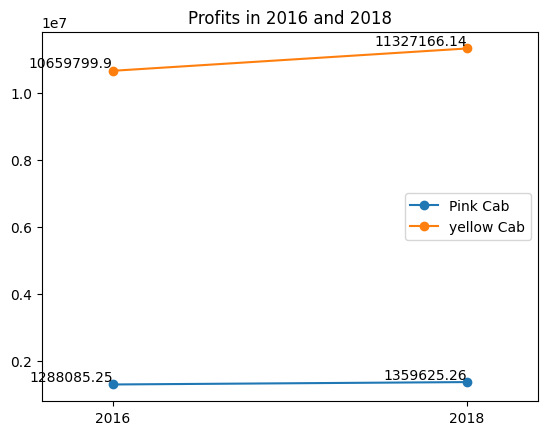

In [2]:


total_profits_pink_2016 = filtered_pink_2016["profits"].sum()
total_profits_pink_2018 = filtered_pink_2018["profits"].sum()
total_profits_yellow_2016 = filtered_yellow_2016["profits"].sum()
total_profits_yellow_2018 = filtered_yellow_2018["profits"].sum()



print('Percent Increase in Pink Cab total yearly profits from 2016 to 2018:',(total_profits_pink_2018 /total_profits_pink_2016) -1)
print('Percent Increase in Yellow Cab total yearly profits from 2016 to 2018:',(total_profits_yellow_2018/total_profits_yellow_2016) -1)



plt.plot([total_profits_pink_2016 , total_profits_pink_2018], marker='o', label='Pink Cab')
plt.plot([total_profits_yellow_2016 , total_profits_yellow_2018], marker='o', label='yellow Cab')

plt.xticks([0,1], ["2016", "2018"])

plt.xlim([-.2,1.2])


plt.text(0, total_profits_pink_2016, f'{round(total_profits_pink_2016,2)}', ha='right', va='bottom')
plt.text(0, total_profits_yellow_2016, f'{round(total_profits_yellow_2016,2)}', ha='right', va='bottom')

plt.text(1, total_profits_pink_2018, f'{round(total_profits_pink_2018,2)}', ha='right', va='bottom')
plt.text(1, total_profits_yellow_2018, f'{round(total_profits_yellow_2018,2)}', ha='right', va='bottom')


plt.title("Profits in 2016 and 2018")
plt.legend()

plt.show()

Insights:

The following cells show the total profits for every distinct group of ten days for the Pink and Yellow cab datasets.

The trend shows that the profits for Pink Cab and Yellow Cab follow a similar pattern.
They each grow linearly from the start of the year and then sharply plummet at the start of the next year.

There is no point where Pink Cab exceeds Yellow cab in profits. 

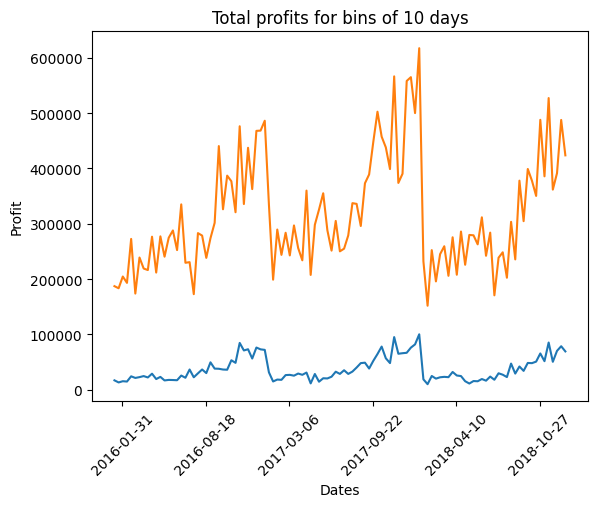

In [3]:
# max date: 43465
# min date: 42371


bins = [42371+i*10 for i in range(110)]


filtered_pink_binned = filtered_pink.groupby(pd.cut(filtered_pink['Date of Travel'], bins), observed= True).agg({'profits': 'sum'}).reset_index(drop=True)
filtered_yellow_binned = filtered_yellow.groupby(pd.cut(filtered_yellow['Date of Travel'], bins), observed= True).agg({'profits': 'sum'}).reset_index(drop=True)

filtered_pink_binned["end_time"] = bins[1:]
filtered_yellow_binned["end_time"] = bins[1:]

pinK_series = filtered_pink_binned["profits"]
yelllow_series = filtered_yellow_binned["profits"]


locs = [item for item in range(42400, 43401, 200)]


ticks = []

for item in locs:
    dt = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + item - 2)
    ticks.append(dt.strftime("%Y-%m-%d"))


plt.xticks(locs, ticks, rotation=45)

plt.plot(filtered_pink_binned["end_time"] ,filtered_pink_binned["profits"])
plt.plot(filtered_yellow_binned["end_time"] ,filtered_yellow_binned["profits"])


plt.title('Total profits for bins of 10 days')
plt.ylabel("Profit")
plt.xlabel("Dates")
plt.show()


Hypothesis: From 2017 to 2018, yellow cabs year to year profit percentage difference outperformed pink cab in the majority of locations. 

Result: (True, it outperformed in 10 out of 19 locations)

Insights:

Generally, this fact would make Yellow cab less susceptible to volatility and maintain its status quo as the superior investment. For example, if a major change in a city happens, Yellow cab is still wide spread enough so that it will not suffer as much of an impact.

However, this is a theoretical insight that might not fully reflect the data. There are many factors to consider.

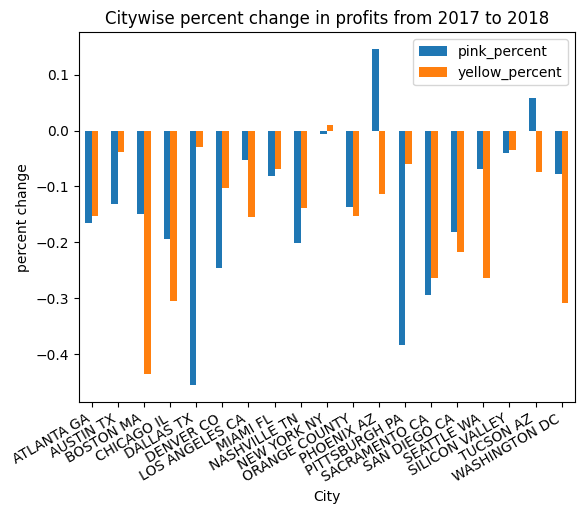

In [4]:

pink_profits_per_city_2017 = filtered_pink_2017.groupby("City").sum("profits")["profits"].sort_index()

pink_profits_per_city_2018 = filtered_pink_2018.groupby("City").sum("profits")["profits"].sort_index()

yellow_profits_per_city_2017 = filtered_yellow_2017.groupby("City").sum("profits")["profits"].sort_index()

yellow_profits_per_city_2018 = filtered_yellow_2018.groupby("City").sum("profits")["profits"].sort_index()


plot_df  = pd.DataFrame()
plot_df["City"] = list(pink_profits_per_city_2017.index)
plot_df["pink_percent"] = [new/old -1 for old, new in zip(pink_profits_per_city_2017, pink_profits_per_city_2018)]
plot_df["yellow_percent"] = [new/old -1 for old, new in zip(yellow_profits_per_city_2017, yellow_profits_per_city_2018)]

ax = plot_df.plot(kind='bar', x='City')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.title("Citywise percent change in profits from 2017 to 2018")

plt.ylabel("percent change")
plt.show()


Pink Cab company:

Null Hypothesis: There is no significant difference in average profit per transaction across quarters.

Alternative Hypothesis: There is a significant difference in average profit per transaction across quarters, indicating seasonality.

Result: reject the NULL Hypothesis

Yellow Cab Company:

Null Hypothesis: There is no significant difference in average profit per transaction across quarters.

Alternative Hypothesis: There is a significant difference in average profit per transaction across quarters, indicating seasonality.

Result: reject the NULL Hypothesis

Insights: 

From visual inspection in the average profit per transaction across quarters, there is no overlap meaning yellow cab has larger average profit per transaction in every year quarter combination.

This is an especially strong observation paired with the knowledge that Yellow cab has by far the higher number of customers year round.
The smallest difference between the two companies is ~65.25 which happens on the four quarter of 2016. However, this difference does not standout as extreme when compared to the difference for the other quarters. This seems to present low competition for Yellow Cab. 


Pink cab results:
Null Hypothesis: There is no significant difference in average profit per transaction across quarters for Pink Cab.
Alternative Hypothesis: There is a significant difference in average profit across quarters for Pink Cab, indicating seasonality.
P_value 0.00042301110288544267
Result: reject the NULL Hypothesis

Yellow cab results:
Null Hypothesis: There is no significant difference in average profit per transaction across quarters for Yellow Cab.
Alternative Hypothesis: There is a significant difference in average profit across quarters for Yellow Cab, indicating seasonality.
P_value 0.007493185836675962
Result: reject the NULL Hypothesis


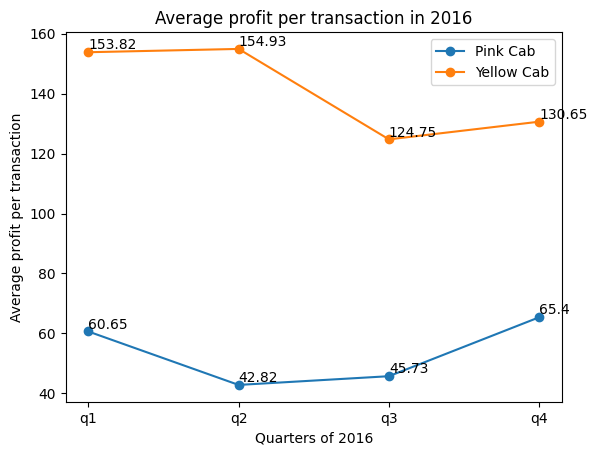

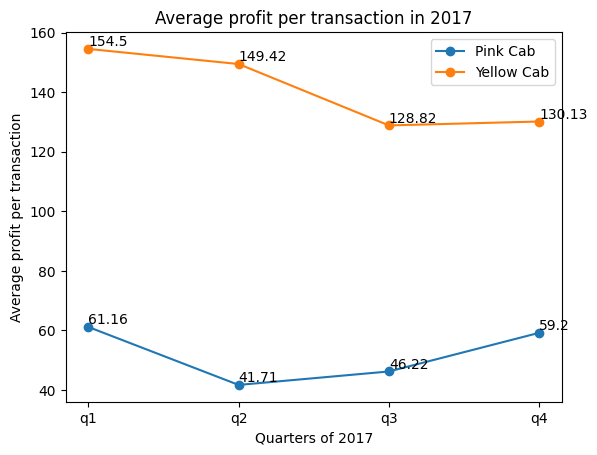

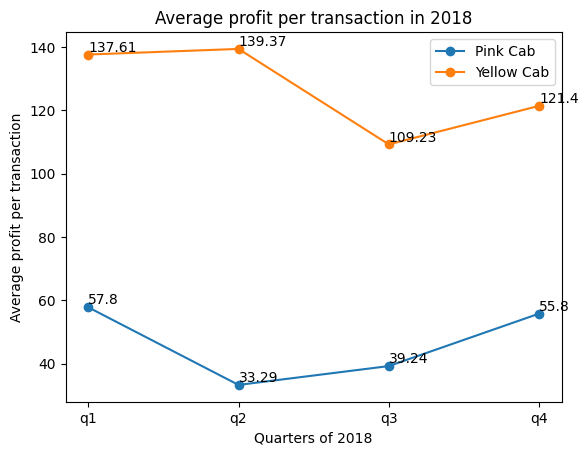

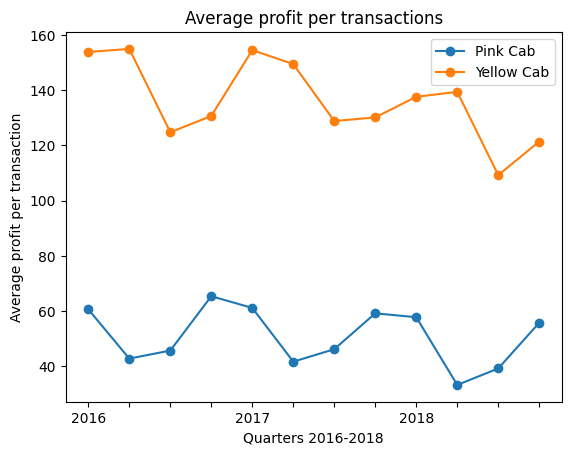

In [5]:

pink_avgs = []
yellow_avgs = []


def avg(series: pd.Series):
    return series.sum()/series.count()


for quarter_start in range(0, 274, 91):
    temp_pink = []
    temp_yellow = []
    for year_start in [42372, 42737, 43102]:
        temp_pink.append(avg(filtered_pink[(filtered_pink["Date of Travel"]>= year_start+quarter_start)&(filtered_pink["Date of Travel"]<= year_start+quarter_start+90)]["profits"]))
        temp_yellow.append(avg(filtered_yellow[(filtered_yellow["Date of Travel"]>= year_start+quarter_start)&(filtered_yellow["Date of Travel"]<= year_start+quarter_start+90)]["profits"]))
    pink_avgs.append(temp_pink)
    yellow_avgs.append(temp_yellow)



_, p_value = stats.f_oneway(*pink_avgs)
print("Pink cab results:")
print("Null Hypothesis: There is no significant difference in average profit per transaction across quarters for Pink Cab.")
print("Alternative Hypothesis: There is a significant difference in average profit across quarters for Pink Cab, indicating seasonality.")
print("P_value", p_value)
print("Result: reject the NULL Hypothesis\n")



_, p_value = stats.f_oneway(*yellow_avgs)
print("Yellow cab results:")
print("Null Hypothesis: There is no significant difference in average profit per transaction across quarters for Yellow Cab.")
print("Alternative Hypothesis: There is a significant difference in average profit across quarters for Yellow Cab, indicating seasonality.")
print("P_value", p_value)
print("Result: reject the NULL Hypothesis")




pink_profit_seq = []
yellow_profit_seq = [] 


for pink_year, yellow_year, year in zip(list(zip(*pink_avgs)), list(zip(*yellow_avgs)), ["2016", "2017", "2018"]):
    plt.plot(["q1", "q2","q3", "q4"], pink_year, label='Pink Cab', marker = "o")
    plt.plot(["q1", "q2","q3", "q4"], yellow_year, label = 'Yellow Cab', marker = "o")
    plt.title("Average profit per transaction in " + year)
    plt.legend()
    plt.xlabel("Quarters of "+year)
    plt.ylabel("Average profit per transaction")
    for pink_month_avg, yellow_month_avg, index in zip(pink_year, yellow_year, range(4)):
        plt.text(index, pink_month_avg, f'{round(pink_month_avg,2)}',  va='bottom')
        plt.text(index, yellow_month_avg, f'{round(yellow_month_avg,2)}', va='bottom')
        pink_profit_seq.append(pink_month_avg)
        yellow_profit_seq.append(yellow_month_avg)
    plt.show()


plt.plot(range(12), pink_profit_seq, marker = "o", label='Pink Cab')
plt.plot(range(12), yellow_profit_seq, marker = "o", label='Yellow Cab')

plt.xticks([0,4,8], [2016, 2017, 2018])
plt.legend()
plt.title("Average profit per transactions")
plt.xlabel("Quarters 2016-2018")
plt.ylabel("Average profit per transaction")
plt.xticks(range(12))


plt.show()


Pink Cab:

Null Hypothesis: There is no difference in profit per transaction between male and female pink cab users.

Alternative Hypothesis: There is a difference in profit per transaction between male and female pink cab users.

Result: Fail to reject the NUll hypothesis


Yellow Cab:

Null Hypothesis: There is no difference in profit per transaction between male and female yellow cab users.

Alternative Hypothesis: There is a difference in profit per transaction between male and female yellow cab users.

Result: Reject the NULL hypothesis


Insights: 

Although the test revels that gender is a factor for profit per transaction for Yellow Cab, it does not change the fact that yellow cab is still dominating in average profit per transaction. There is no gender where pink cab is making close to what yellow cab is making.

Null Hypothesis: There is no difference in profit per transaction between male and female pink cab users.
Alternate Hypothesis: There is a difference in profit per transaction between male and female pink cab users.
p_value: 0.48433017388557853
Result: Fail to reject the Null Hypothesis

Null Hypothesis: There is no difference in profit per transaction between male and female Yellow cab users.
Alternate Hypothesis: There is a difference in profit per transaction between male and female Yellow cab users.
p_value: 6.2678826504275026e-15
Result: Reject the Null Hypothesis


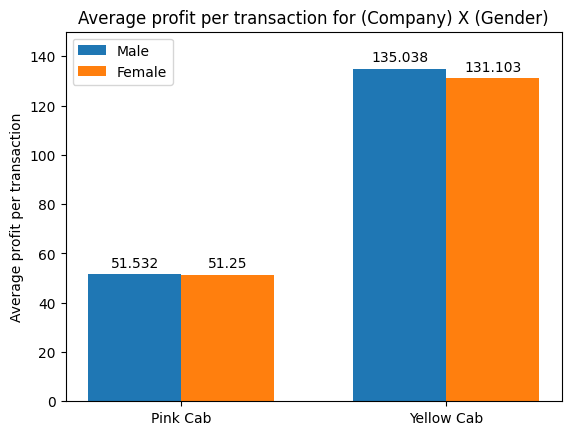

In [6]:

pink_males_filtered_profits = filtered_pink[filtered_pink["Gender"] == "Male"]["profits"]
pink_females_filtered_profits = filtered_pink[filtered_pink["Gender"] == "Female"]["profits"]
yellow_males_filtered_profits = filtered_yellow[filtered_yellow["Gender"] == "Male"]["profits"]
yellow_females_filtered_profits = filtered_yellow[filtered_yellow["Gender"] == "Female"]["profits"]



average_profit_pink_male = pink_males_filtered_profits.sum()/pink_males_filtered_profits.size
average_profit_pink_female =  pink_females_filtered_profits.sum()/pink_females_filtered_profits.size
average_profit_yellow_male =  yellow_males_filtered_profits.sum()/yellow_males_filtered_profits.size
average_profit_yellow_female = yellow_females_filtered_profits.sum()/yellow_females_filtered_profits.size



#Note: Does not need function: too many differences

t_statistic, p_value = stats.ttest_ind(pink_males_filtered_profits, pink_females_filtered_profits)

print("Null Hypothesis: There is no difference in profit per transaction between male and female pink cab users.")
print("Alternate Hypothesis: There is a difference in profit per transaction between male and female pink cab users.")
print('p_value:', p_value)
print("Result: Fail to reject the Null Hypothesis\n")

t_statistic, p_value = stats.ttest_ind(yellow_males_filtered_profits, yellow_females_filtered_profits)

print("Null Hypothesis: There is no difference in profit per transaction between male and female Yellow cab users.")
print("Alternate Hypothesis: There is a difference in profit per transaction between male and female Yellow cab users.")
print('p_value:', p_value)
print("Result: Reject the Null Hypothesis")


x = np.arange(2)

fig, ax = plt.subplots()
bar1 = ax.bar(x - 0.35/2, [average_profit_pink_male,average_profit_yellow_male], 0.35, label='Male')
bar2 = ax.bar(x + 0.35/2, [average_profit_pink_female,average_profit_yellow_female], 0.35, label='Female')

ax.set_ylabel('Average profit per transaction')
ax.set_title('Average profit per transaction for (Company) X (Gender)')
ax.set_xticks(x)
ax.set_xticklabels(['Pink Cab', 'Yellow Cab'])
ax.legend()


def label(bars):
    for bar in bars:
        height = round(bar.get_height(), 3)
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

label(bar1)
label(bar2)
plt.ylim([0,150])
plt.show()



For all years:

Null Hypothesis: At the 3 rides retention mark there is no difference in user retention between yellow cab and pink cab

Alt Hypothesis: At the 3 rides retention mark yellow cab has higher user retention than pink cab

Result: Reject the Null Hypothesis


Insights: 

It can be visually inspected that Yellow cab has significantly higher user retention across all retention levels for all years.
When pink cabs user retention is close to zero at the 7 ride retention level yellows cabs user retention is in the tenths and is at least ~84 times larger.

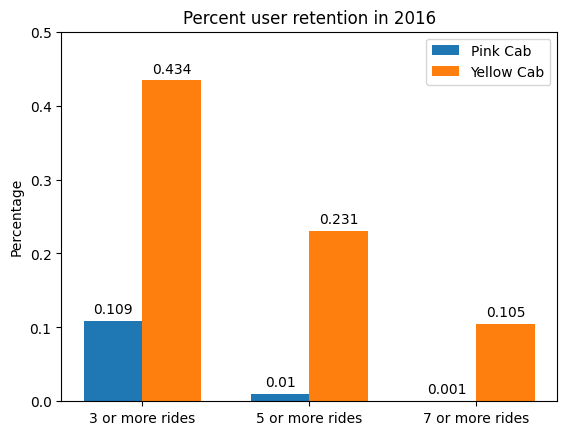

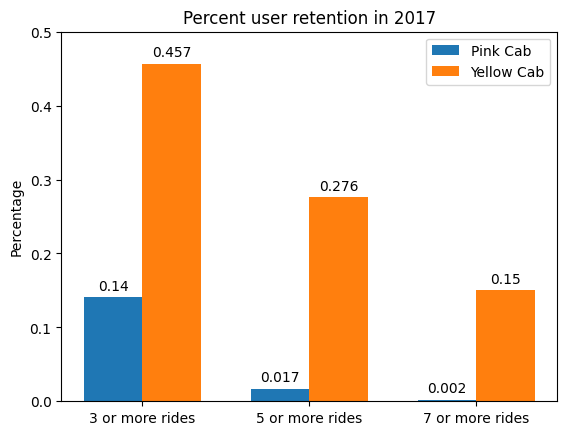

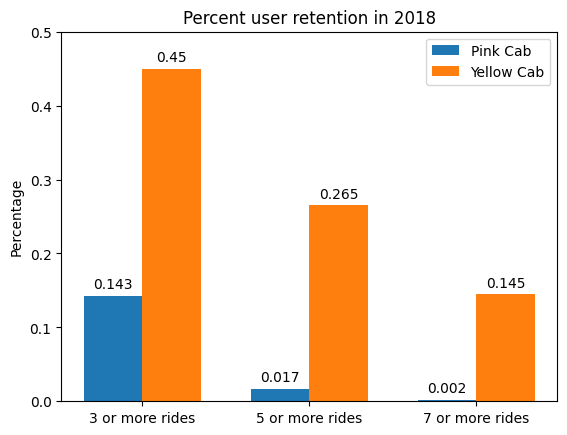

Null Hypothesis: At the 3 rides retention mark there is no difference in user retention between yellow and pink cab in 2016.
Alternate Hypothesis: At the 3 rides retention mark yellow has higher user retention than pink cab in 2016.
p_value: 0.0
Result: Reject the Null Hypothesis



In [7]:


pink_series_2016 = filtered_pink_2016.groupby("Customer ID")["Customer ID"].count()
yellow_series_2016 = filtered_yellow_2016.groupby("Customer ID")["Customer ID"].count()
pink_series_2017 = filtered_pink_2017.groupby("Customer ID")["Customer ID"].count()
yellow_series_2017 = filtered_yellow_2017.groupby("Customer ID")["Customer ID"].count()
pink_series_2018 = filtered_pink_2018.groupby("Customer ID")["Customer ID"].count()
yellow_series_2018 = filtered_yellow_2018.groupby("Customer ID")["Customer ID"].count()



def plot_year(pink_series, yellow_series, year):

    pink_ls = []
    yellow_ls = []
    for threshold in [3, 5, 7]:
        pink_ls.append(len(pink_series[pink_series>=threshold])/pink_series.size)
        yellow_ls.append(len(yellow_series[yellow_series>=threshold])/yellow_series.size)

    x = np.arange(3)

    _, ax = plt.subplots()
    bar1 = ax.bar(x - 0.35/2, pink_ls, 0.35, label='Pink Cab')
    bar2 = ax.bar(x + 0.35/2, yellow_ls, 0.35, label='Yellow Cab')

    ax.set_ylabel('Percentage')
    ax.set_title('Percent user retention in ' + year)
    ax.set_xticks(x)
    ax.set_xticklabels(['3 or more rides', '5 or more rides', '7 or more rides'])
    ax.legend()


    def label(bars):
        for bar in bars:
            height = round(bar.get_height(), 3)
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom')

    label(bar1)
    label(bar2)
    plt.ylim([0,.5])
    plt.show()



plot_year(pink_series_2016, yellow_series_2016, "2016")
plot_year(pink_series_2017, yellow_series_2017, "2017")
plot_year(pink_series_2018, yellow_series_2018, "2018")


_, p_value = sm.stats.proportions_ztest(
    [len(pink_series_2016[pink_series_2016>=3]), 
     len(yellow_series_2016[yellow_series_2016>=3])], 
    [pink_series_2016.size, yellow_series_2016.size], alternative='smaller')


print("Null Hypothesis: At the 3 rides retention mark there is no difference in user retention between yellow and pink cab in 2016.")
print("Alternate Hypothesis: At the 3 rides retention mark yellow has higher user retention than pink cab in 2016.")
print('p_value:', p_value)
print("Result: Reject the Null Hypothesis\n")




Fore each Cab company:

Null Hypothesis: There is no relationship between the cost per transaction and charge per transaction.

Alternative Hypothesis: There is a positive relationship between the cost per transaction and charge per transaction.

result: reject the Null Hypothesis

Insights: 

The identity line (in black) is present to show what it looks like when the charge is equal to the cost per transaction for every transaction.
In this case no profit is being made or lost.

Trends following a line with a higher y intercept and slope will always indicate net profit.

Both the slope and y intercept of the regression line (in red) is higher for yellow cab than it is for pink cab.
This means that the difference in profits between yellow cab and pink cab is also growing as the cost of the transaction increases.

Yellow Cab results:

Null Hypothesis: There is no relationship between the cost per transaction and charge per transaction.
Alternative Hypothesis: There is a positive relationship between the cost per transaction and charge per transaction.
p_value: 0.0
Result: Reject the Null Hypothesis

Regression line:
Slope: 1.3505597695044127
Intercept: 32.458653920800074
How strong is the linear relationship?
r2_score: 0.7809370469005827


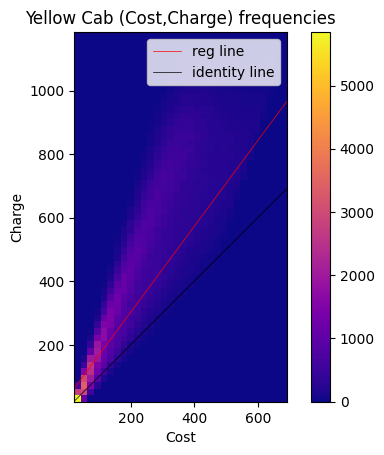

Pink Cab results:

Null Hypothesis: There is no relationship between the cost per transaction and charge per transaction.
Alternative Hypothesis: There is a positive relationship between the cost per transaction and charge per transaction.
p_value: 0.0
Result: Reject the Null Hypothesis

Regression line:
Slope: 1.1586840990111629
Intercept: 13.21657992553186
How strong is the linear relationship?
r2_score: 0.8958606283008338


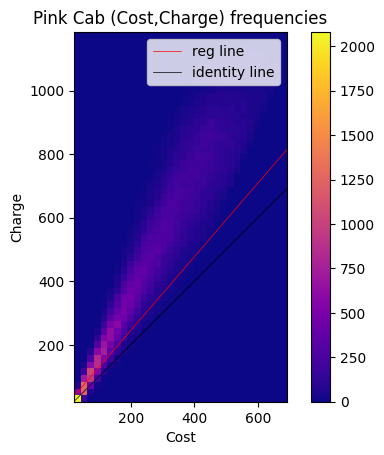

In [8]:

print("Yellow Cab results:\n")

m, b = np.polyfit(filtered_yellow["Cost of Trip"], filtered_yellow["Price Charged"], 1)

print("Null Hypothesis: There is no relationship between the cost per transaction and charge per transaction.")
print("Alternative Hypothesis: There is a positive relationship between the cost per transaction and charge per transaction.")
result = stats.linregress(filtered_yellow["Cost of Trip"], filtered_yellow["Price Charged"])
print('p_value:', result.pvalue)
print("Result: Reject the Null Hypothesis")

x_limits = [filtered_yellow["Cost of Trip"].min(),
filtered_yellow["Cost of Trip"].max()]
y_limits = m * np.array(x_limits) + b
y_pred = m * np.array(filtered_yellow["Cost of Trip"]) + b

print("\nRegression line:")
print("Slope:", m)
print("Intercept:", b)
print("How strong is the linear relationship?")
print('r2_score:', r2_score(filtered_yellow["Price Charged"], y_pred))

hist, xedges, yedges = np.histogram2d(
    filtered_yellow["Cost of Trip"], 
    filtered_yellow["Price Charged"],
    bins=(55, 32))

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(hist, extent = extent, cmap='plasma',origin='lower', interpolation='nearest')
plt.colorbar()
plt.title("Yellow Cab (Cost,Charge) frequencies")
plt.xlabel("Cost")
plt.ylabel("Charge")
plt.xlim(xedges[0], xedges[-1])  
plt.ylim(yedges[0], yedges[-1])  
plt.plot(x_limits, y_limits, color='red', linestyle='-', linewidth=.5, label = "reg line")
plt.plot([0, xedges[-1]], [0, xedges[-1]], color='black', linestyle='-', linewidth=.5, label = "identity line")
plt.legend()
plt.show()




print("Pink Cab results:\n")

m, b = np.polyfit(filtered_pink["Cost of Trip"], filtered_pink["Price Charged"], 1)

print("Null Hypothesis: There is no relationship between the cost per transaction and charge per transaction.")
print("Alternative Hypothesis: There is a positive relationship between the cost per transaction and charge per transaction.")
result = stats.linregress(filtered_pink["Cost of Trip"], filtered_pink["Price Charged"])
print('p_value:', result.pvalue)
print("Result: Reject the Null Hypothesis")

x_limits = [filtered_yellow["Cost of Trip"].min(),
filtered_yellow["Cost of Trip"].max()]
y_limits = m * np.array(x_limits) + b
y_pred = m * np.array(filtered_pink["Cost of Trip"]) + b

print("\nRegression line:")
print("Slope:", m)
print("Intercept:", b)
print("How strong is the linear relationship?")
print('r2_score:', r2_score(filtered_pink["Price Charged"], y_pred))

hist, _, _ = np.histogram2d(
    filtered_pink["Cost of Trip"], 
    filtered_pink["Price Charged"],
    bins=(55, 32))

plt.imshow(hist, extent = extent, cmap='plasma',origin='lower', interpolation='nearest')
plt.colorbar()
plt.title("Pink Cab (Cost,Charge) frequencies")
plt.xlabel("Cost")
plt.ylabel("Charge")
plt.xlim(xedges[0], xedges[-1])  
plt.ylim(yedges[0], yedges[-1])  
plt.plot(x_limits, y_limits, color='red', linestyle='-', linewidth=.5, label = "reg line")
plt.plot([0, xedges[-1]], [0, xedges[-1]], color='black', linestyle='-', linewidth=.5, label = "identity line")
plt.legend()
plt.show()



Null Hypothesis: The proportion (users in Young age group for pink cab):(difference in the number of users from Young age group to Middle Aged age group for pink cab) is equal to the proportion (users in Young age group for yellow cab):(difference in the number of users from Young age group to Middle Aged age group for yellow cab).

Alternate Hypothesis: The proportion (users in Young age group for pink cab):(difference in the number of users from Young age group to Middle Aged age group for pink cab) is not equal to the proportion (users in Young age group for yellow cab):(difference in the number of users from Young age group to Middle Aged age group for yellow cab).

Result: Fail to reject the Null Hypothesis

Insights:
 
What this essentially means is that the growth from the young to middle ages between the two cab companies is somewhat similar in nature relative to their respective Young Age frequencies.
Another way to understand it is that the multiplicative scaling from young to middle ages is relatively similar between Cab companies.

This shows the continued support for yellow cab since it is easy to see that age in general scales the number of users for both companies. 

It is unlikely that pink cab will appeal to an age group that yellow cab wont be able to appeal to in the same way.
This reduces the risk of a potentially shifting age group disrupting the status quo of Yellow Cabs dominance.

Null Hypothesis: The proportion (users in Young age group for pink cab):(difference in the number of users from Young age group to Middle Aged age group for pink cab)...
is equal to the proportion (users in Young age group for yellow cab):(difference in the number of users from Young age group to Middle Aged age group for yellow cab).

Alternate Hypothesis: The proportion (users in Young age group for pink cab):(difference in the number of users from Young age group to Middle Aged age group for pink cab)...
is not equal to the proportion (users in Young age group for yellow cab):(difference in the number of users from Young age group to Middle Aged age group for yellow cab).

p_value: 0.3517809501942094
Result: Fail to reject the Null Hypothesis


C:\Users\jackson\AppData\Local\Temp\ipykernel_53188\828869510.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_users["age group"] = age_groups
C:\Users\jackson\AppData\Local\Temp\ipykernel_53188\828869510.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_users["age group"] = age_groups


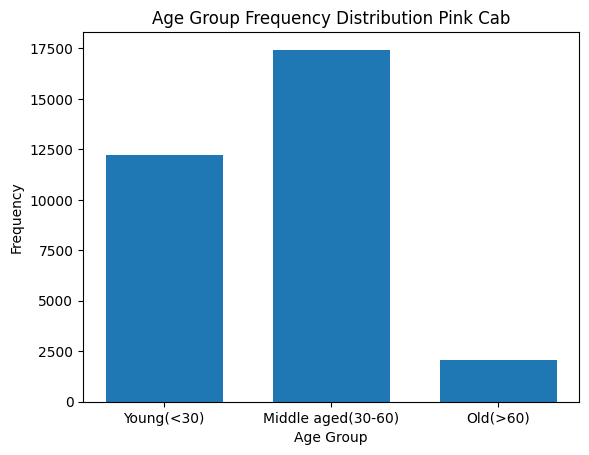

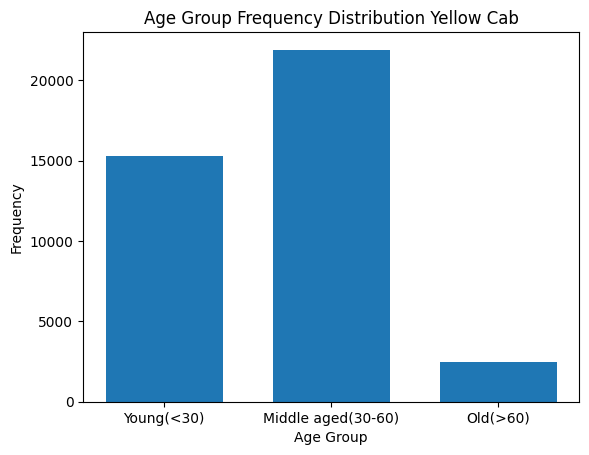

In [9]:

filtered_pink_users = filtered_pink.drop_duplicates("Customer ID")
filtered_yellow_users = filtered_yellow.drop_duplicates("Customer ID")


def age_group_freq(filtered_users):
    age_groups = []
    for age in filtered_users["Age"]:
        if(age<30):
            age_groups.append("Young")
        elif(age>=30 and age<60):
            age_groups.append("Middle Aged")
        else:
            age_groups.append("Old")
    filtered_users["age group"] = age_groups

    age_group_freq = filtered_users.groupby("age group")["age group"].count()
    age_group_freq = age_group_freq[["Young", "Middle Aged", "Old"]]

    return age_group_freq


pink_age_group_freq = age_group_freq(filtered_pink_users)
yellow_age_group_freq = age_group_freq(filtered_yellow_users)


total_pink_users_young = pink_age_group_freq["Young"]
total_yellow_users_young = yellow_age_group_freq["Young"]
pink_change_in_users = (pink_age_group_freq["Middle Aged"] - pink_age_group_freq["Young"])
yellow_change_in_users = (yellow_age_group_freq["Middle Aged"] - yellow_age_group_freq["Young"])



_, p_value = proportions_ztest(np.array([pink_change_in_users, yellow_change_in_users]), np.array([total_pink_users_young, total_yellow_users_young]))


print("Null Hypothesis: The proportion (users in Young age group for pink cab):(difference in the number of users from Young age group to Middle Aged age group for pink cab)...")
print("is equal to the proportion (users in Young age group for yellow cab):(difference in the number of users from Young age group to Middle Aged age group for yellow cab).\n")

print("Alternate Hypothesis: The proportion (users in Young age group for pink cab):(difference in the number of users from Young age group to Middle Aged age group for pink cab)...")
print("is not equal to the proportion (users in Young age group for yellow cab):(difference in the number of users from Young age group to Middle Aged age group for yellow cab).\n")

print('p_value:', p_value)
print("Result: Fail to reject the Null Hypothesis")



def plot_age_groups(age_group_freq, company):
    fig, ax = plt.subplots()
    ax.bar(["Young(<30)", "Middle aged(30-60)", "Old(>60)"], age_group_freq.values, width=0.7, align='center')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Frequency')
    ax.set_title('Age Group Frequency Distribution '+ company)
    plt.show()


plot_age_groups(pink_age_group_freq, "Pink Cab")
plot_age_groups(yellow_age_group_freq, "Yellow Cab")




Hypothesis: Yellow cab has higher user frequencies across all age groups

Insights:

This visualization shows that the dominance of the previous visualization holds when the data is divided into more age groups with smaller bounds.
Yet again, there is more customers for Yellow cab for each age group.

The difference in frequencies follow a similar pattern to the histograms. This means the more frequent the age group the higher the difference in frequency between the companies.

The age min for pink cab: 18.0
Is The same as...
The age min for yellow cab 18.0

The age max for pink cab: 65.0
Is The same as...
The age max for yellow cab: 65.0


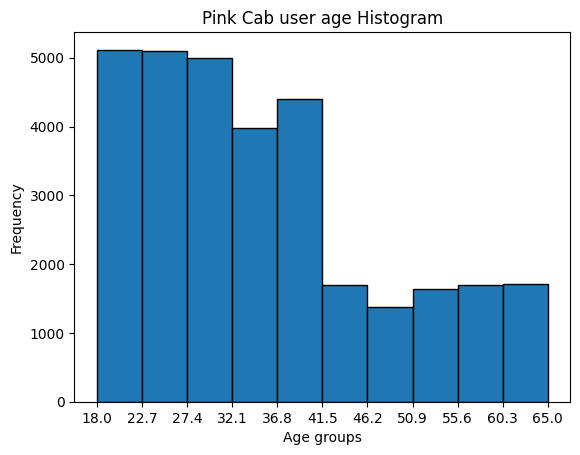

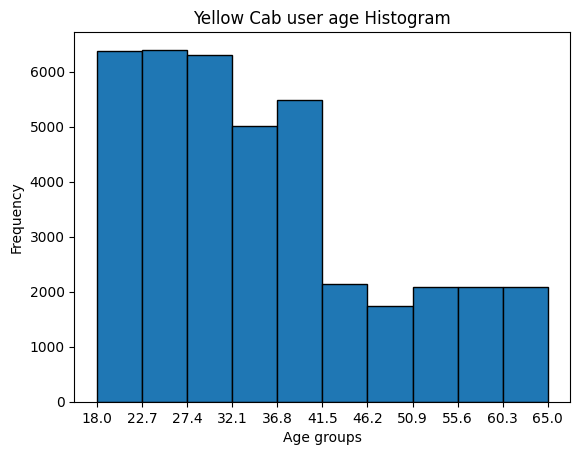

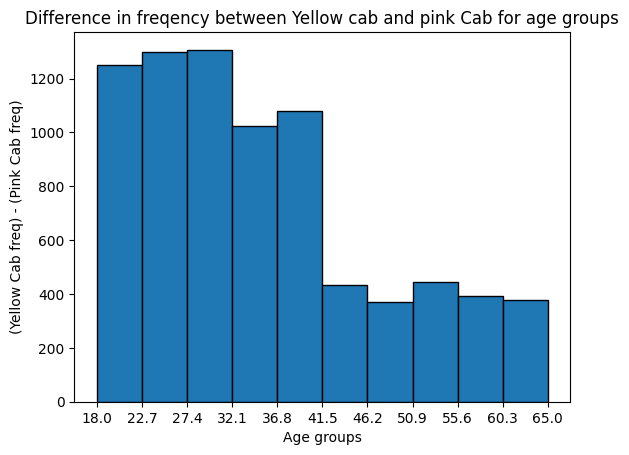

In [10]:

filtered_pink_user_ages = filtered_pink.drop_duplicates("Customer ID")["Age"]
filtered_yellow_user_ages = filtered_yellow.drop_duplicates("Customer ID")["Age"]



print("The age min for pink cab:", min(filtered_pink_user_ages))
print("Is The same as...")
print("The age min for yellow cab", min(filtered_yellow_user_ages))

print("\nThe age max for pink cab:", max(filtered_pink_user_ages))
print("Is The same as...")
print("The age max for yellow cab:", max(filtered_yellow_user_ages))



x_ticks = np.arange(18,66,(max(filtered_pink_user_ages)- min(filtered_pink_user_ages))/10)


pink_freq, _ = np.histogram(filtered_pink_user_ages, bins=10)  
yellow_freq, _ = np.histogram(filtered_yellow_user_ages, bins=10)  


def plot_hist(filtered_user_ages, company):
    plt.hist(filtered_user_ages, bins=10, edgecolor='black')
    plt.xlabel('Age groups')
    plt.ylabel('Frequency')
    plt.title(company+' user age Histogram')
    plt.xticks(x_ticks)
    plt.show()


plot_hist(filtered_pink_user_ages, "Pink Cab")
plot_hist(filtered_yellow_user_ages, "Yellow Cab")

plt.bar(np.arange(18,65,(max(filtered_pink_user_ages)- min(filtered_pink_user_ages))/10), yellow_freq - pink_freq, width=4.7, align='edge', edgecolor='black')
plt.title("Difference in freqency between Yellow cab and pink Cab for age groups")
plt.xlabel('Age groups')
plt.ylabel('(Yellow Cab freq) - (Pink Cab freq)')
plt.xticks(x_ticks)
plt.show()




In conclusion, from the above insights, the recommendation is to invest in Yellow Cab. 